## Exploratory Data Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('fivethirtyeight')

In [2]:
# Read the cleaned data
clean_data = pd.read_csv("data/clean_data.csv")

### 1. What is the distribution of the target variable? How many samples were toxic, how many were not?
I know there were a lot of zeros in the target variable from doing data cleaning. Let's see how many.

In [3]:
print('There are {} zeros in Domoic Acid values out of {} entries'\
      .format(sum(clean_data['Domoic Acid (ng/mL)']==0), len(clean_data)))

There are 2155 zeros in Domoic Acid values out of 2750 entries


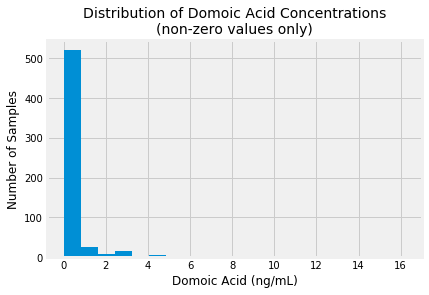

In [4]:
# Plot the distribution of non-zero values.
_ = plt.hist(clean_data.loc[clean_data['Domoic Acid (ng/mL)']>0, 'Domoic Acid (ng/mL)'], bins=20)
_ = plt.xlabel('Domoic Acid (ng/mL)')
_ = plt.ylabel('Number of Samples')
_ = plt.title('Distribution of Domoic Acid Concentrations\n(non-zero values only)', fontsize=14)

Most of the values are small. Plotting in log scale might present a better picture in the distribution.<br>
According to personal communication with domoic acid expert Dr. Jayme Smith, domoic acid concentration of 0.5ng/mL or above can be considered dangerous. Let's also add that information to the plot.

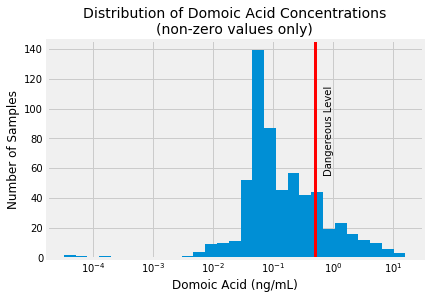

In [5]:
# Try log scale
plot_data = clean_data.loc[clean_data['Domoic Acid (ng/mL)']>0, 'Domoic Acid (ng/mL)']
# Create log bins
logbins = np.logspace(np.log10(min(plot_data)), np.log10(max(plot_data)), 30)
_ = plt.hist(plot_data, bins=logbins)
_ = plt.xlabel('Domoic Acid (ng/mL)')
_ = plt.ylabel('Number of Samples')
_ = plt.title('Distribution of Domoic Acid Concentrations\n(non-zero values only)', fontsize=14)
_ = plt.xscale('log')
# Add a vertical line marking the dangerous level
_ = plt.axvline(x=0.5, color='red', lw=3)
_ = plt.text(0.7, 110, 'Dangereous Level', rotation=90)

In [6]:
print('There are {} samples that had dangerous Domoic Acid values out of {} entries'\
      .format(sum(clean_data['Domoic Acid (ng/mL)']>=0.5), len(clean_data)))

There are 120 samples that had dangerous Domoic Acid values out of 2750 entries


### 2. Relationships between the dependent variable and independent variables.
#### 2.1 Is there any seasonal or monthly pattern of toxic events (domoic acid above dangerous level)?

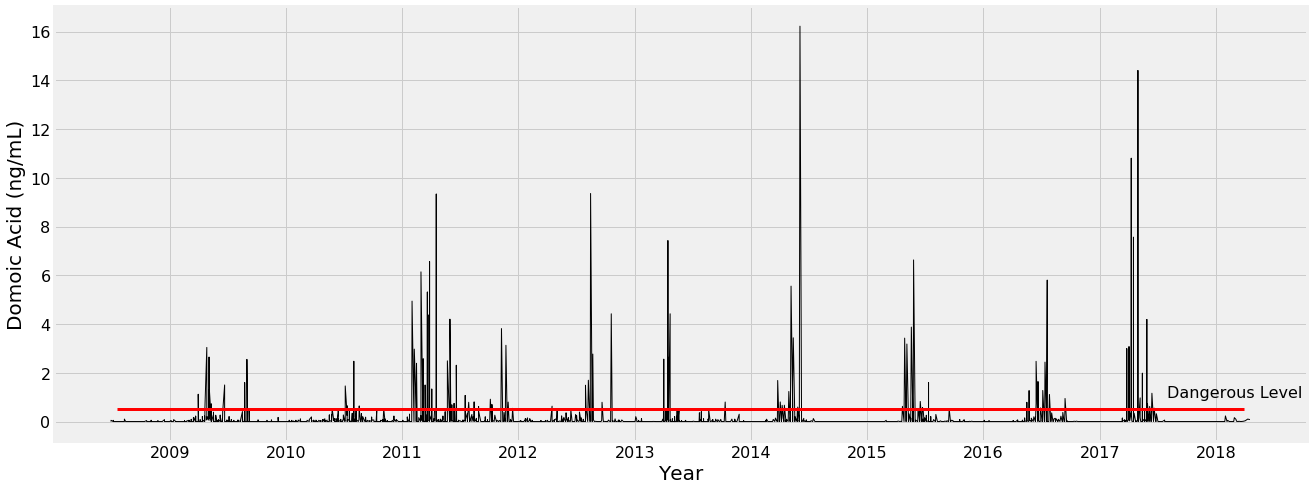

In [7]:
# Plot the dependent variable against sample collection dates
clean_data['date'] = pd.to_datetime(clean_data['date'])
plt.figure(figsize=(20, 8))
_ = plt.plot_date(clean_data['date'], clean_data['Domoic Acid (ng/mL)'], 'k-', lw=1)
_ = plt.xlabel('Year', fontsize = 20)
_ = plt.ylabel('Domoic Acid (ng/mL)', fontsize = 20)
_ = plt.xticks(fontsize = 16)
_ = plt.yticks(fontsize = 16)
_ = plt.axhline(y=0.5, color='red', lw=3, xmin=0.05, xmax=0.95)
_ = plt.text(pd.to_datetime('2017-08-01'), 1, 'Dangerous Level', fontsize=16)

We can see most of the toxic events occured during spring or summer. Let's do some plots and statistical tests to see if it is true.

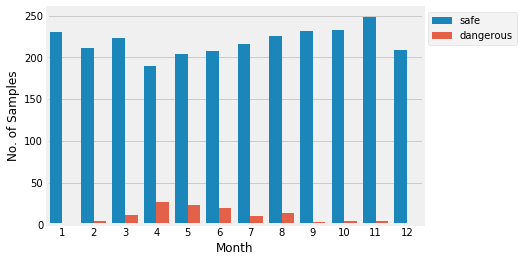

In [8]:
# Plot a bar chart of domoic acid values (dangerous or safe) in different months
clean_data['month'] = clean_data['date'].dt.month
clean_data['dangerous'] = clean_data['Domoic Acid (ng/mL)']>=0.5
_ = sns.countplot(x='month', hue='dangerous', data=clean_data)
_ = plt.legend(['safe', 'dangerous'], bbox_to_anchor=(1, 1))
_ = plt.xlabel('Month')
_ = plt.ylabel('No. of Samples')

In [9]:
# Conduct a Chi-square test to see if probability of dangerous levels are independent from month.
from scipy.stats import chi2_contingency
crosstab = pd.crosstab(clean_data['month'], clean_data['dangerous'])
results = chi2_contingency(crosstab)
print('chi2 = {}\tp = {}'.format(results[0], results[1]))

chi2 = 98.79729714424599	p = 3.0892853950497483e-16


**This confirms that probability of toxic events were different in different months. It looks like spring (April, May, June) is the most dangerous season for domoic acid toxic events.**

#### 2.2 Is there any relationship between toxin levels and concentrations of different chemicals in the ocean?
My hypothesis is chlorophyll will have a positive correlation with toxin levels, because more chlorophyll means more algae, which might mean more toxin. Some but not all nutrients might have positive correlation with toxin levels too, because more nutrients mean favorable growth conditions for algae.

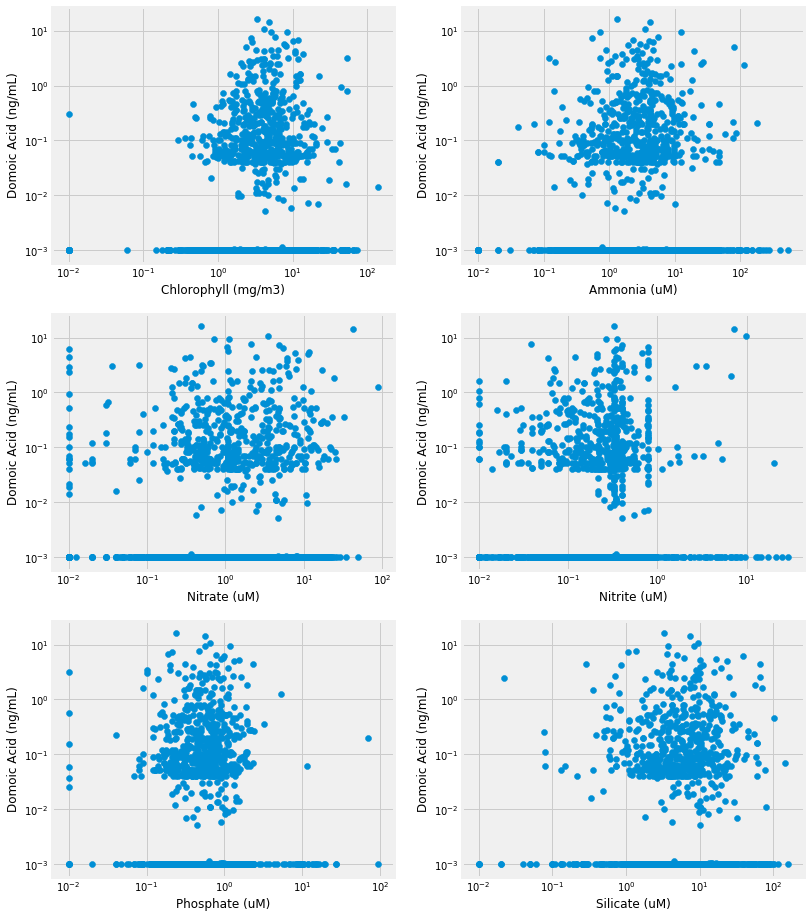

In [10]:
# Scatter plots
cols = ['Chlorophyll (mg/m3)', 'Ammonia (uM)', 'Nitrate (uM)', 'Nitrite (uM)', 'Phosphate (uM)', 'Silicate (uM)']
plt.figure(figsize=(12, 16))
for index, value in enumerate(cols):
    plt.subplot(3, 2, index+1)
    _ = plt.xscale('log')
    _ = plt.yscale('log')
    _ = plt.scatter(clean_data[value]+0.01, clean_data['Domoic Acid (ng/mL)']+0.001)
    _ = plt.xlabel(value)
    _ = plt.ylabel('Domoic Acid (ng/mL)')

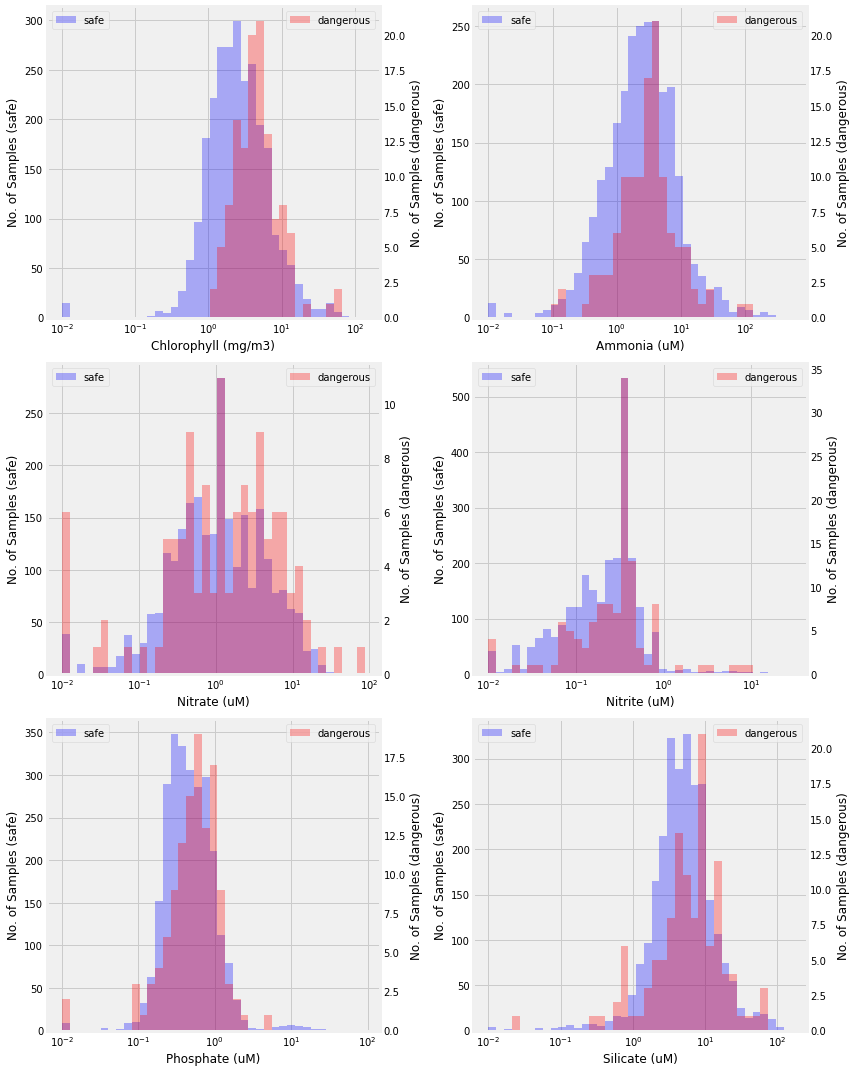

In [11]:
# No clear trend observed.
# Try a different kind of plot (histograms for different levels of domoic acid)
plt.figure(figsize=(12, 15))
for index, value in enumerate(cols):
    ax1 = plt.subplot(3, 2, index+1)
    # Create log bins, add 0.01 to data to avoid division by zero
    logbins = np.logspace(np.log10(min(clean_data[value])+0.01), np.log10(max(clean_data[value])+0.01), 40)
    dangerous = clean_data.loc[clean_data['dangerous']==True, value]+0.01
    safe = clean_data.loc[clean_data['dangerous']==False, value]+0.01
    # Plot the safe group
    ax1.hist(safe, bins=logbins, color='blue', alpha=0.3, label='safe')
    ax1.set_xscale('log')
    ax1.set_xlabel(value)
    ax1.set_ylabel('No. of Samples (safe)')
    ax1.legend(loc=2)
    # Plot the dangerous group on second y axis
    ax2 = ax1.twinx()
    ax2.hist(dangerous, bins=logbins, color='red', alpha=0.3, label='dangerous')
    ax2.grid(False)
    ax2.set_ylabel('No. of Samples (dangerous)')
    ax2.legend(loc=1)
plt.tight_layout()

Looks like higher chlorophyll concentrations were associated with higher probabilities of dangerous domoic acid levels. The relationship between dependent variable and other chemical variables were not as clear. Maybe there was a positive correlation with nitrate, nitrite, and silicate, but I am not sure if they were significant. Let's do some statistic tests to see if the log-means of chemical variables were significantly different dangerous and safe groups.<br><br>
Sample distributions after log transformation looked approximately normal. Sample sizes were large enough to use the z test.

In [12]:
#Use z-test on log-transformed data
from statsmodels.stats.weightstats import CompareMeans
for col in cols:
    #Log transform
    dangerous = np.log(clean_data.loc[clean_data['dangerous']==True, col]+0.01)
    safe = np.log(clean_data.loc[clean_data['dangerous']==False, col]+0.01)
    #z test
    data = CompareMeans.from_data(dangerous, safe)
    z, p = CompareMeans.ztest_ind(data)
    print('For {}, z = {}, p = {}'.format(col, z, p))

For Chlorophyll (mg/m3), z = 6.576771060376074, p = 4.80774151759041e-11
For Ammonia (uM), z = 1.7260983232997442, p = 0.08432972544092032
For Nitrate (uM), z = 1.1453904388884744, p = 0.25204745716573984
For Nitrite (uM), z = 2.737647264276109, p = 0.006188040801150625
For Phosphate (uM), z = 1.2803673589341065, p = 0.20041596803367345
For Silicate (uM), z = 1.569782990815459, p = 0.11646560599195105


We select alpha = 0.01, only tests for chlorophyll and nitrite were significant. **Higher chlorophyll and nitrite concentrations were associated with higer risk of toxic events.**

#### 2.3 Do abundances of different algae affect risk of toxic events?
I know domoic acid is produced by Psuedo-nitzschia, so I expect their cell concentrations to be positively correlated with risk of toxic events and/or toxin concentration. Other organisms don't produce domoic acid, but it is possible that they have effects on toxin production through biological interactions. It would be interesting to find out.

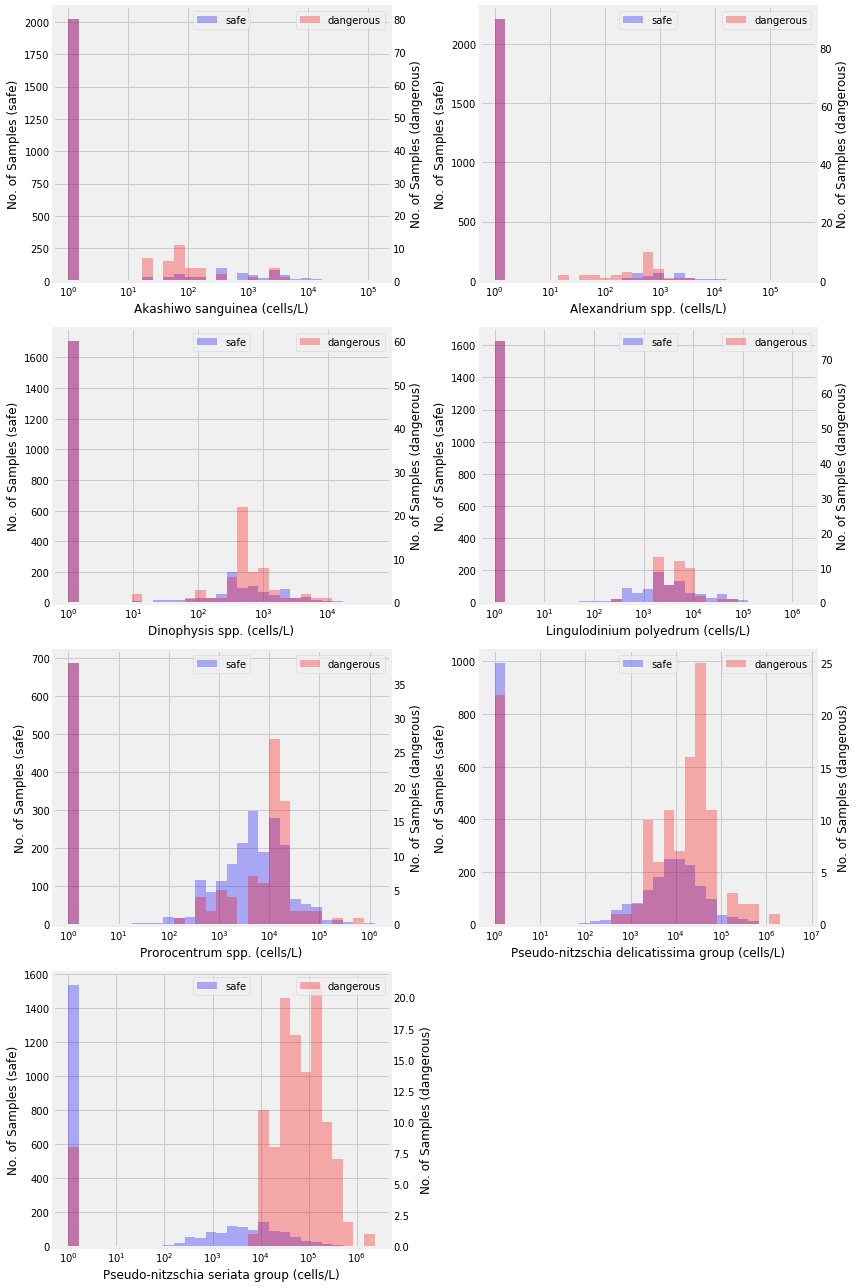

In [13]:
# Let's use histograms similar to those above, as they were more effetive than scatterplots.
cols = ['Akashiwo sanguinea (cells/L)', 'Alexandrium spp. (cells/L)', 'Dinophysis spp. (cells/L)',
        'Lingulodinium polyedrum (cells/L)', 'Prorocentrum spp. (cells/L)',
        'Pseudo-nitzschia delicatissima group (cells/L)', 'Pseudo-nitzschia seriata group (cells/L)']
plt.figure(figsize=(12, 18))
for index, value in enumerate(cols):
    ax1 = plt.subplot(4, 2, index+1)
    # Create log bins, add 1 to data to avoid division by zero
    logbins = np.logspace(np.log10(min(clean_data[value])+1), np.log10(max(clean_data[value])+1), 30)
    dangerous = clean_data.loc[clean_data['dangerous']==True, value]+1
    safe = clean_data.loc[clean_data['dangerous']==False, value]+1
    # Plot the safe group
    ax1.hist(safe, bins=logbins, color='blue', alpha=0.3, label='safe')
    ax1.set_xscale('log')
    ax1.set_xlabel(value)
    ax1.set_ylabel('No. of Samples (safe)')
    ax1.legend(loc=9)
    # Plot the dangerous group on second y axis
    ax2 = ax1.twinx()
    ax2.hist(dangerous, bins=logbins, color='red', alpha=0.3, label='dangerous')
    ax2.grid(False)
    ax2.set_ylabel('No. of Samples (dangerous)')
    ax2.legend(loc=1)
plt.tight_layout()

Clearly, Pseudo-nitzschia seriata cell counts had a positive correlation with risk of toxic events. So does Pseudo-nitzschia delicatissima, but to a lesser degree. Other organisms had minimal if any impact on risk of toxic events. Let's do some statistical tests to see if they back up my visual observations.<br><br>
There were a lot of zeros in the data, and the overall distribution is definitely not normal. I'll conduct two different tests for two different questions.<br>
First, does risk of toxic events differ in samples where the cell counts were zero and those where the cell counts were not zero? To answer this, I will use a chi-square test.

In [14]:
for col in cols:
    positive = clean_data[col] > 0
    crosstab = pd.crosstab(positive, clean_data['dangerous'])
    results = chi2_contingency(crosstab)
    print('For {}, p = {}'.format(col, results[1]))

For Akashiwo sanguinea (cells/L), p = 0.014851863275044994
For Alexandrium spp. (cells/L), p = 0.013799961545893554
For Dinophysis spp. (cells/L), p = 0.0013003687422870514
For Lingulodinium polyedrum (cells/L), p = 0.9445867821295838
For Prorocentrum spp. (cells/L), p = 0.21054440865318608
For Pseudo-nitzschia delicatissima group (cells/L), p = 2.495038491308745e-05
For Pseudo-nitzschia seriata group (cells/L), p = 1.8294543103695384e-28


For alpha = 0.01, only tests for Pseudo-nitzschia seriata, Pseudo-nitzschia delicatissima, and Dinophysis spp. were significant.<br><br>
Second, for those three organisms, the distribution of non-zero values looks approximately normal after log transformation. I will use a t-test (for Dinophysis spp., the sample size is a little small) to see if the log-mean of cell counts were different between dangerous and safe group.

In [15]:
from scipy.stats import ttest_ind
cols = ['Dinophysis spp. (cells/L)', 'Pseudo-nitzschia delicatissima group (cells/L)',
        'Pseudo-nitzschia seriata group (cells/L)']
for col in cols:
    # Extract only positive values, and log transform them
    dangerous = np.log(clean_data.loc[(clean_data['dangerous']==True) & (clean_data[col]>0), col])
    safe = np.log(clean_data.loc[(clean_data['dangerous']==False) & (clean_data[col]>0), col])
    t, p = ttest_ind(dangerous, safe)
    print('For {}, t = {}, p = {}'.format(col, t, p))

For Dinophysis spp. (cells/L), t = -0.05391237606491358, p = 0.9570159307418125
For Pseudo-nitzschia delicatissima group (cells/L), t = 4.439184950532085, p = 9.599456828436002e-06
For Pseudo-nitzschia seriata group (cells/L), t = 14.809344386367522, p = 1.0289917494308599e-45


Only tests for the two Pseudo-nitzschia groups were significant. **A positive measurement of Dinophysis spp. were associated with higher risk of toxic events, but concentrations of Dinophysis spp. between safe and dangerous groups were not different. Concentrations of two Pseudo-nitzschia groups were significantly different between safe and dangerous groups**<br><br>
Let's visulize the relationship between the concentrations of the two Pseudo-nitzschia groups and toxin concentrations.

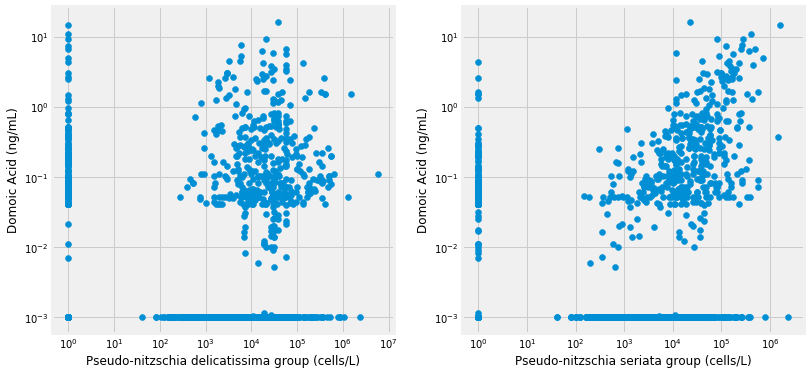

In [17]:
cols = ['Pseudo-nitzschia delicatissima group (cells/L)', 'Pseudo-nitzschia seriata group (cells/L)']
plt.figure(figsize=(12,6))
for index, value in enumerate(cols):
    plt.subplot(1, 2, index+1)
    _ = plt.xscale('log')
    _ = plt.yscale('log')
    _ = plt.scatter(clean_data[value]+1, clean_data['Domoic Acid (ng/mL)']+0.001)
    _ = plt.xlabel(value)
    _ = plt.ylabel('Domoic Acid (ng/mL)')

**It looks like a weak linear relationship exists between domoic acid concentrations and Pseudo-nitzschia seriata cell concentrations.** The was no clear linear relationship between domoic acid concentrations and Pseudo-nitzschia delicatissima cell concentrations.

#### 2.4 Does climate conditions (temperature and climate indices) affect the risk of toxic events?
My hopythesis is that there has to be an optimal range of temperatures for best conditions for toxin production. Too hot or too cold are not good for any algae. Higher upwelling index means more nutrients to the surface, therefore more favorable conditions for algae growth. My hypothesis is that higher upwelling index is associated with higher risk of toxic events.

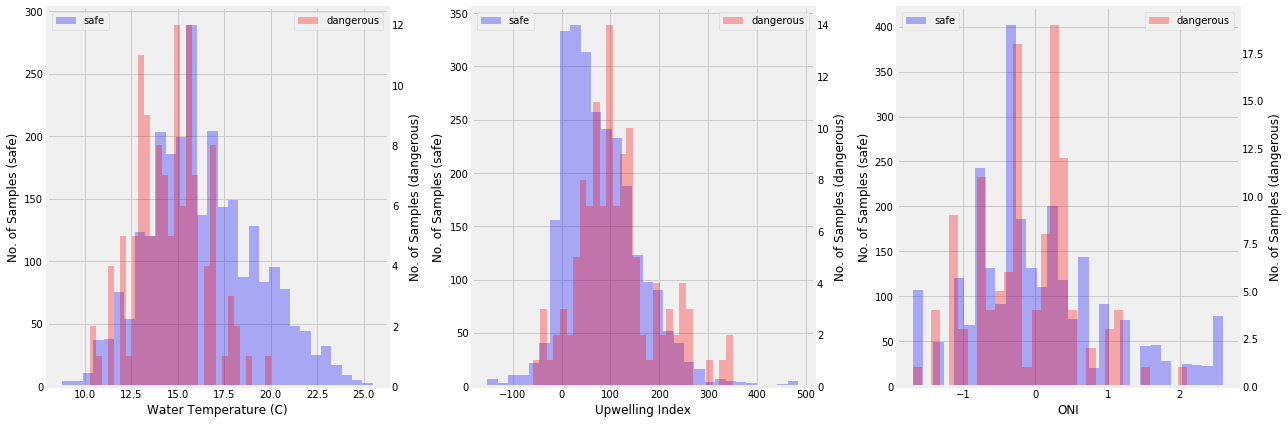

In [18]:
# Histogram
cols = ['Water Temperature (C)', 'Upwelling Index', 'ONI']
plt.figure(figsize=(18, 6))
for index, value in enumerate(cols):
    ax1 = plt.subplot(1, 3, index+1)
    dangerous = clean_data.loc[clean_data['dangerous']==True, value]
    not_dangerous = clean_data.loc[clean_data['dangerous']==False, value]
    ln1 = ax1.hist(not_dangerous, bins=30, color='blue', alpha=0.3, label='safe')
    ax1.set_xlabel(value)
    ax1.set_ylabel('No. of Samples (safe)')
    ax1.legend(loc=2)
    ax2 = ax1.twinx()
    ln2 = ax2.hist(dangerous, bins=30, color='red', alpha=0.3, label='dangerous')
    ax2.grid(False)
    ax2.set_ylabel('No. of Samples (dangerous)')
    ax2.legend(loc=1)
plt.tight_layout()

**It appears dangerous levels of domoic acid levels only occur within a certain range of water temperatures (between 10 and 20 degrees), and occurs most often when temperatures were between 12 and 18 degrees).<br>
It also appears higher upwelling indices were associated with higher probability of dangerous domoic acid levels.**<br>
Let's run statistical tests to find out if our observations are correct.

In [19]:
for col in cols:
    dangerous = clean_data.loc[clean_data['dangerous']==True, col]
    safe = clean_data.loc[clean_data['dangerous']==False, col]
    data = CompareMeans.from_data(dangerous, safe)
    z, p = CompareMeans.ztest_ind(data)
    print('For {}, z = {}, p = {}'.format(col, z, p))

For Water Temperature (C), z = -6.789182585484357, p = 1.1277064841609732e-11
For Upwelling Index, z = 4.4888518965085575, p = 7.160805841210518e-06
For ONI, z = -1.6283866938151748, p = 0.10344291726639629


Statistical tests corroborated what we observed in the charts.

### 3. Is there any correlation between independent variables? Are there any highly correlated (predictable) variable pairs?
Highly correlated independent variables are not good for machine learning models. We want to avoid them.

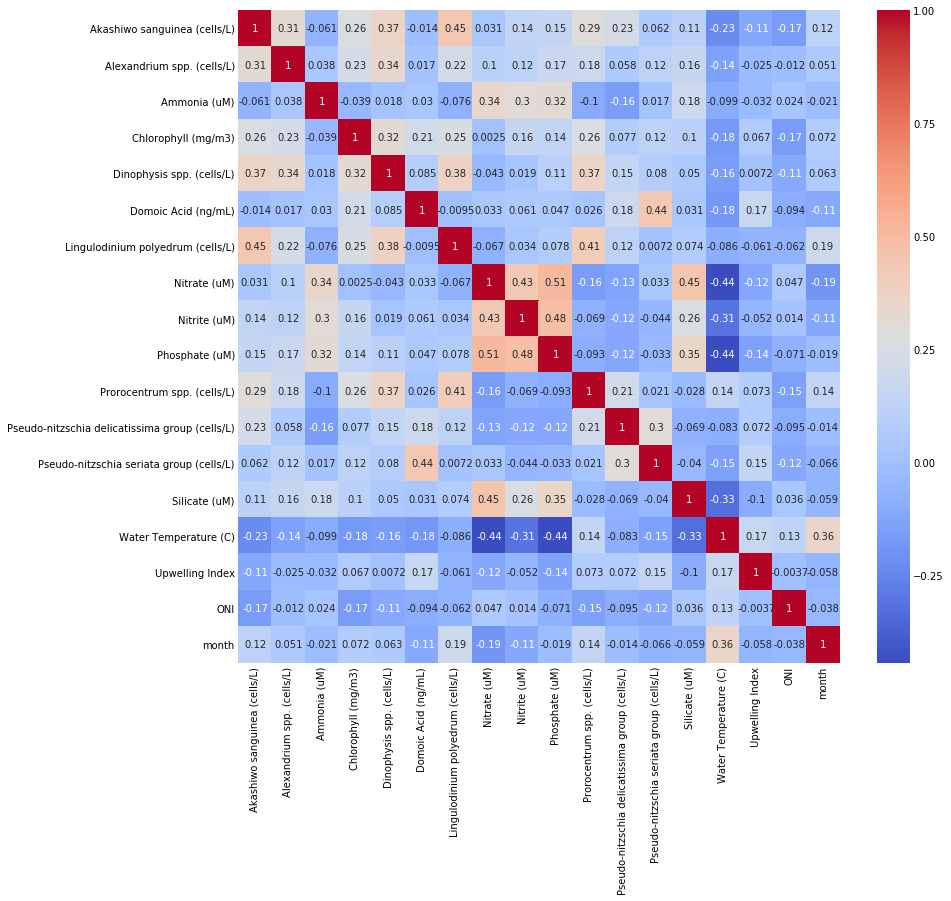

In [20]:
# Drop the columns that won't be included in the correlation analysis.
plot_data = clean_data.drop(['dangerous', 'date'], axis=1)
# Log transform the columns that have skewed distribution
plot_data['Domoic Acid (ng/mL)'] = np.log(plot_data['Domoic Acid (ng/mL)']+0.001)
cols = ['Chlorophyll (mg/m3)', 'Ammonia (uM)', 'Nitrate (uM)',
        'Nitrite (uM)', 'Phosphate (uM)', 'Silicate (uM)']
for col in cols:
    plot_data[col] = np.log(plot_data[col]+0.01)
cols = ['Akashiwo sanguinea (cells/L)', 'Alexandrium spp. (cells/L)',
        'Dinophysis spp. (cells/L)', 'Lingulodinium polyedrum (cells/L)',
        'Prorocentrum spp. (cells/L)', 'Pseudo-nitzschia delicatissima group (cells/L)',
        'Pseudo-nitzschia seriata group (cells/L)']
for col in cols:
    plot_data[col] = np.log(plot_data[col]+1)
# Plot heatmap of correlation
plt.figure(figsize=(12,12))
corr_table = plot_data.corr()
_ = sns.heatmap(corr_table, annot=True, cmap='coolwarm')

There were no pairs of variables with correlations so high that they need to be removed. The largest correlation coefficients were between a few nutrient concentrations and water temperature. This is a known phenomenon. When ocean upwelling events happen, it brings cold, nutrient rich water to the surface. That's why nutrient concentrations are somewhat correlated, and negatively correlated with water temperatures.<br>
From this analysis, we can also see which independent variable has the largest correlation coefficients with the dependent variable. **The features that were most correlated with target variable were Pseudo-nitzschia seriata, chlorophyll, water temperature, upwelling index, and Pseudo-nitzschia delicatissima.**